In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import os
import cv2
import matplotlib.pyplot as plt

from pathlib import Path
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
i=0;
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        i+=1
        print(os.path.join(dirname, filename))
        if(i>10):
            break

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/captcha-version-2-images/samples/7wyp4.png
/kaggle/input/captcha-version-2-images/samples/6wb76.png
/kaggle/input/captcha-version-2-images/samples/c6f8g.png
/kaggle/input/captcha-version-2-images/samples/4c8n8.png
/kaggle/input/captcha-version-2-images/samples/ec6pm.png
/kaggle/input/captcha-version-2-images/samples/fpw76.png
/kaggle/input/captcha-version-2-images/samples/e7x45.png
/kaggle/input/captcha-version-2-images/samples/6end3.png
/kaggle/input/captcha-version-2-images/samples/c4bgd.png
/kaggle/input/captcha-version-2-images/samples/n4cpy.png
/kaggle/input/captcha-version-2-images/samples/88bgx.png
/kaggle/input/captcha-version-2-images/samples/samples/7wyp4.png


# **Loading images**

In [2]:
data_dir = Path("../input/captcha-version-2-images/samples/")
images = list(data_dir.glob("*.png"))

# Creating labelled data
As we know that each of our image contains a line , basically a thin line which cuts several characters.
So we are going to remove that line by morphological operations on our image(Erosion and dilation).
First we wil threshold our image , we are gonna use Adaptive thresolding , then we will dilate to remove that line.
Its also clearly visible that each image contains 5 characters and the positions of all 5 characters are always same.
So we wil hardcode character's position and from each image we will extract five characters with their corresponding label , and hence will get a labelled data.
We wil pad each character image to change it in required dimension.

**Defining function for padding**

In [3]:
kernel =np.ones((3,1),np.uint8)
borderType = cv2.BORDER_CONSTANT
def pad(src): 
    top = int(0.05 * src.shape[0])  # shape[0] = rows
    bottom = top
    left = int(0.15 * src.shape[1])  # shape[1] = cols
    right = left
    des=cv2.copyMakeBorder(src, top, bottom, left+1, right, borderType, None,255)
    return cv2.bitwise_not(des)

**CREATING LABELLED DATA**

In [4]:
x=[]
y=[]
for image in images:
    im=cv2.imread(str(image),0)
    threshold=cv2.adaptiveThreshold(im, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY, 199, 5)
    erosion =cv2.dilate(threshold,kernel,iterations=2)
    s=str(image)
    for i in range(5):
        x.append(pad(erosion[:,(30+23*i):(30+23*(i+1))]))
        y.append(s[-9+i])

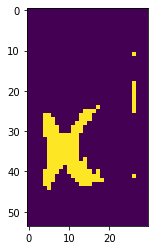

In [5]:
plt.imshow(x[56])

In [6]:
y[56]

'x'

In [7]:
x=np.array(x)
y=np.array(y)

**TO see which characters are present and their corresponding frequencies , to ensure that our data is not biased**

In [8]:
(unique, counts) = np.unique(y, return_counts=True)
frequencies = np.asarray((unique, counts)).T

print(frequencies)

[['2' '265']
 ['3' '267']
 ['4' '284']
 ['5' '281']
 ['6' '259']
 ['7' '258']
 ['8' '264']
 ['b' '240']
 ['c' '262']
 ['d' '259']
 ['e' '235']
 ['f' '271']
 ['g' '271']
 ['m' '275']
 ['n' '525']
 ['p' '253']
 ['w' '235']
 ['x' '264']
 ['y' '232']]


In [9]:
data=np.reshape(x,(-1,54,30,1))

# Converting labels in one-hot encoder form

In [10]:
train = []
l=['2','3','4','5','6','7','8','b','c','d','e','f','g','m','n','p','w','x','y']
for j in y:
    i=l.index(j)
    a=[]
    for r in range(19):
        if(r==i):
            a.append(1)
        else:
            a.append(0)
    a=np.array(a)
    train.append(a)
train=np.array(train)    

# **Importing libraries to definne our model**

In [11]:
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau


sns.set(style='white', context='notebook', palette='deep')

# **Defining architecture of our Model**

In [12]:
model = Sequential()
model.add(Conv2D(filters = 16, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (50,30,1)))
model.add(Conv2D(filters = 16, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(19, activation = "softmax"))

**Optimizer Functions**

In [13]:
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [14]:
epochs = 30 # Turn epochs to 30 to get 0.9967 accuracy
batch_size = 86

**Splitting Data**

In [15]:
X_train, X_val, Y_train, Y_val = train_test_split(data, train, test_size = 0.1, random_state= 2)
X_train=X_train/255.0
X_val=X_val/255.0

# Data Augmentation

In [16]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=5,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = False, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(X_train)

# Fitting data into the Model

In [17]:
history = model.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs =  30, validation_data = (X_val,Y_val),
                              verbose = 1, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])

Epoch 1/30
54/54 [==============================] - 2s 41ms/step - loss: 2.6138 - accuracy: 0.1894 - val_loss: 1.4217 - val_accuracy: 0.6346
Epoch 2/30
54/54 [==============================] - 2s 35ms/step - loss: 1.8516 - accuracy: 0.4327 - val_loss: 0.8673 - val_accuracy: 0.7904
Epoch 3/30
54/54 [==============================] - 2s 36ms/step - loss: 1.2763 - accuracy: 0.6088 - val_loss: 0.7419 - val_accuracy: 0.7750
Epoch 4/30
54/54 [==============================] - 2s 41ms/step - loss: 0.9519 - accuracy: 0.7042 - val_loss: 0.4635 - val_accuracy: 0.8558
Epoch 5/30
54/54 [==============================] - 2s 35ms/step - loss: 0.7124 - accuracy: 0.7797 - val_loss: 0.3790 - val_accuracy: 0.8827
Epoch 6/30
54/54 [==============================] - 2s 35ms/step - loss: 0.6083 - accuracy: 0.8124 - val_loss: 0.3497 - val_accuracy: 0.8788
Epoch 7/30
54/54 [==============================] - 2s 35ms/step - loss: 0.5048 - accuracy: 0.8476 - val_loss: 0.2762 - val_accuracy: 0.9192
Epoch 8/30
54

# Analysing losses

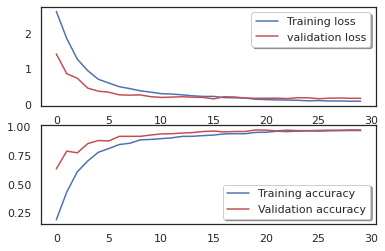

In [18]:
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

# Analysing out top-6 wrongly identified characters

Predicted label :9
True label :8
Predicted label :13
True label :14
Predicted label :0
True label :14
Predicted label :14
True label :8
Predicted label :16
True label :15
Predicted label :13
True label :4


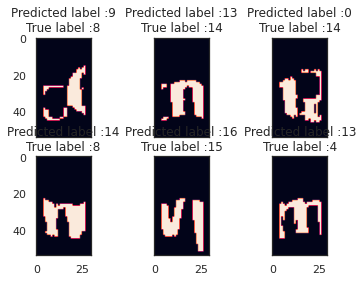

In [19]:
Y_pred = model.predict(X_val)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val,axis = 1) 
errors = (Y_pred_classes - Y_true != 0)

Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = Y_pred[errors]
Y_true_errors = Y_true[errors]
X_val_errors = X_val[errors]

def display_errors(errors_index,img_errors,pred_errors, obs_errors):
    """ This function shows 6 images with their predicted and real labels"""
    n = 0
    nrows = 2
    ncols = 3
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True)
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((54,30)))
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[error],obs_errors[error]))
            print("Predicted label :{}\nTrue label :{}".format(pred_errors[error],obs_errors[error]))
            n += 1

# Probabilities of the wrong predicted numbers
Y_pred_errors_prob = np.max(Y_pred_errors,axis = 1)

# Predicted probabilities of the true values in the error set
true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))

# Difference between the probability of the predicted label and the true label
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors

# Sorted list of the delta prob errors
sorted_dela_errors = np.argsort(delta_pred_true_errors)

# Top 6 errors 
most_important_errors = sorted_dela_errors[-6:]

# Show the top 6 errors
display_errors(most_important_errors, X_val_errors, Y_pred_classes_errors, Y_true_errors)

# Analysis on Cpatcha images
Til now we have evaluated and traied our model on charcter dataset, what we are going to do here is test the accuracy of our model on captcha images.
A captcha image is said to be correctly predicted if all the characters in that image are correcty identified. 

In [20]:
def captcha(img,p):
    im=cv2.imread(str(img),0)
    threshold=cv2.adaptiveThreshold(im, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY, 199, 5)
    erosion =cv2.dilate(threshold,kernel,iterations=2)
    images=[]
    for i in range(5):
        images.append(pad(erosion[:,(30+23*i):(30+23*(i+1))]))
    images=np.reshape(images,(-1,54,30,1))
    pred=model.predict(images)
    pred=np.argmax(pred,axis = 1)
    predicted=str(l[pred[0]]+l[pred[1]]+l[pred[2]]+l[pred[3]]+l[pred[4]])
    if(p):
        print(predicted)
    if(predicted==img[-9:-4]):
        return 1
    return 0
    

In [21]:
images = list(data_dir.glob("*.png"))
t=0
for i in images:
    t+=captcha(str(i),False)

# Acuuracy

In [22]:
print("total images",len(images),"correctly identified",t)
print("Accuracy is",t/len(images))

total images 1040 correctly identified 961
Accuracy is 0.9240384615384616


# Let's Test a single captcha code

In [23]:
img='/kaggle/input/captcha-version-2-images/samples/y48c3.png'
captcha(img,True)

y48c3


1